# 8 Combining Analysis - Feature Selection & Visualisations

This notebook outlines the final feature selection techniques employed to refine the generated time series to be predicted by machine learning models.

In [30]:
#Library imports
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import scipy

from sklearn.preprocessing import StandardScaler
import seaborn as sns
from pylab import rcParams

import os

import math
import json
import itertools
import requests
import time
from datetime import datetime, timedelta, timezone
import random

from mpl_toolkits.mplot3d import Axes3D
from matplotlib.figure import Figure

from sklearn.decomposition import PCA 

from sklearn.feature_selection import RFE
from sklearn import metrics
from sklearn.svm import SVR
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from IPython.display import clear_output

%matplotlib inline

## 8.1 Load Masterframe

In [31]:
df = pd.read_csv("./Data/Masterframe.csv")
df = df.set_index(df.Date).drop(columns=['Date'])
df

,Open,High,Low,Close,Volume,Adj_Close,HL_Avg,High_MA,Low_MA,HL_Avg_Rolling,...,Reddit Sentiment 2,News Sentiment 2,Twitter Sentiment Return,Reddit Sentiment Return,News Sentiment Return,Twitter Sentiment MA,Reddit Sentiment MA,News Sentiment MA,Raw_Labels,Smoothed_Labels
Date,,,,,,,,,,,,,,,,,,,,,
2011-02-19,1.01370,1.01432,1.01290,1.01409,2514.3501,1.006532,1.013610,1.014410,1.007990,1.011200,...,0.6369,0.196048,-0.146809,-0.216518,2.052308,0.579110,0.361100,0.053305,-1,-1
2011-02-20,1.01426,1.01533,1.00749,1.00954,84486.1273,1.006837,1.011410,1.015180,1.009817,1.012498,...,0.6369,0.196048,-0.146809,-0.216518,2.052308,0.579110,0.361100,0.053305,-1,-1
2011-02-21,1.00952,1.00979,0.99682,0.99899,186337.6789,1.006041,1.003305,1.013147,1.005737,1.009442,...,0.6369,0.196048,-0.172071,-0.276353,-1.117956,0.579110,0.361100,0.053305,1,1
2011-02-22,0.99898,1.00599,0.99831,1.00234,159643.3362,1.005666,1.002150,1.010370,1.000873,1.005622,...,0.4990,0.598400,-0.207832,-0.381889,1.569088,0.579110,0.361100,0.053305,1,1
2011-02-23,1.00234,1.01240,1.00027,1.00889,173690.4416,1.005992,1.006335,1.009393,0.998467,1.003930,...,0.3611,-0.070585,-0.500000,-0.617832,0.522034,0.579110,0.361100,0.053305,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-24,0.70572,0.70706,0.70374,0.70422,3801.4900,0.716184,0.705400,0.708810,0.703490,0.706150,...,-0.4215,-0.409500,-0.074228,-1.000000,1.292208,-0.067937,-0.279892,-0.173858,1,-1
2018-12-25,0.70428,0.70723,0.70333,0.70693,77848.7096,0.715259,0.705280,0.707087,0.703533,0.705310,...,-0.2960,-0.203622,-0.005433,0.000000,0.563739,-0.288996,-0.342044,-0.407712,-1,-1
2018-12-26,0.70693,0.70786,0.70173,0.70352,193196.9914,0.714085,0.704795,0.707383,0.702933,0.705158,...,0.0000,-0.466744,-0.005462,-1.000000,-0.044346,-0.473994,-0.268480,-0.501447,1,-1


## 8.2 Manual Feature Selection

This approach looks at manual feature selection through observing the cross correlation between input features. In this naive approach, all correlations above a threshold are flagged as multicollinear and so are pruned from the dataset.

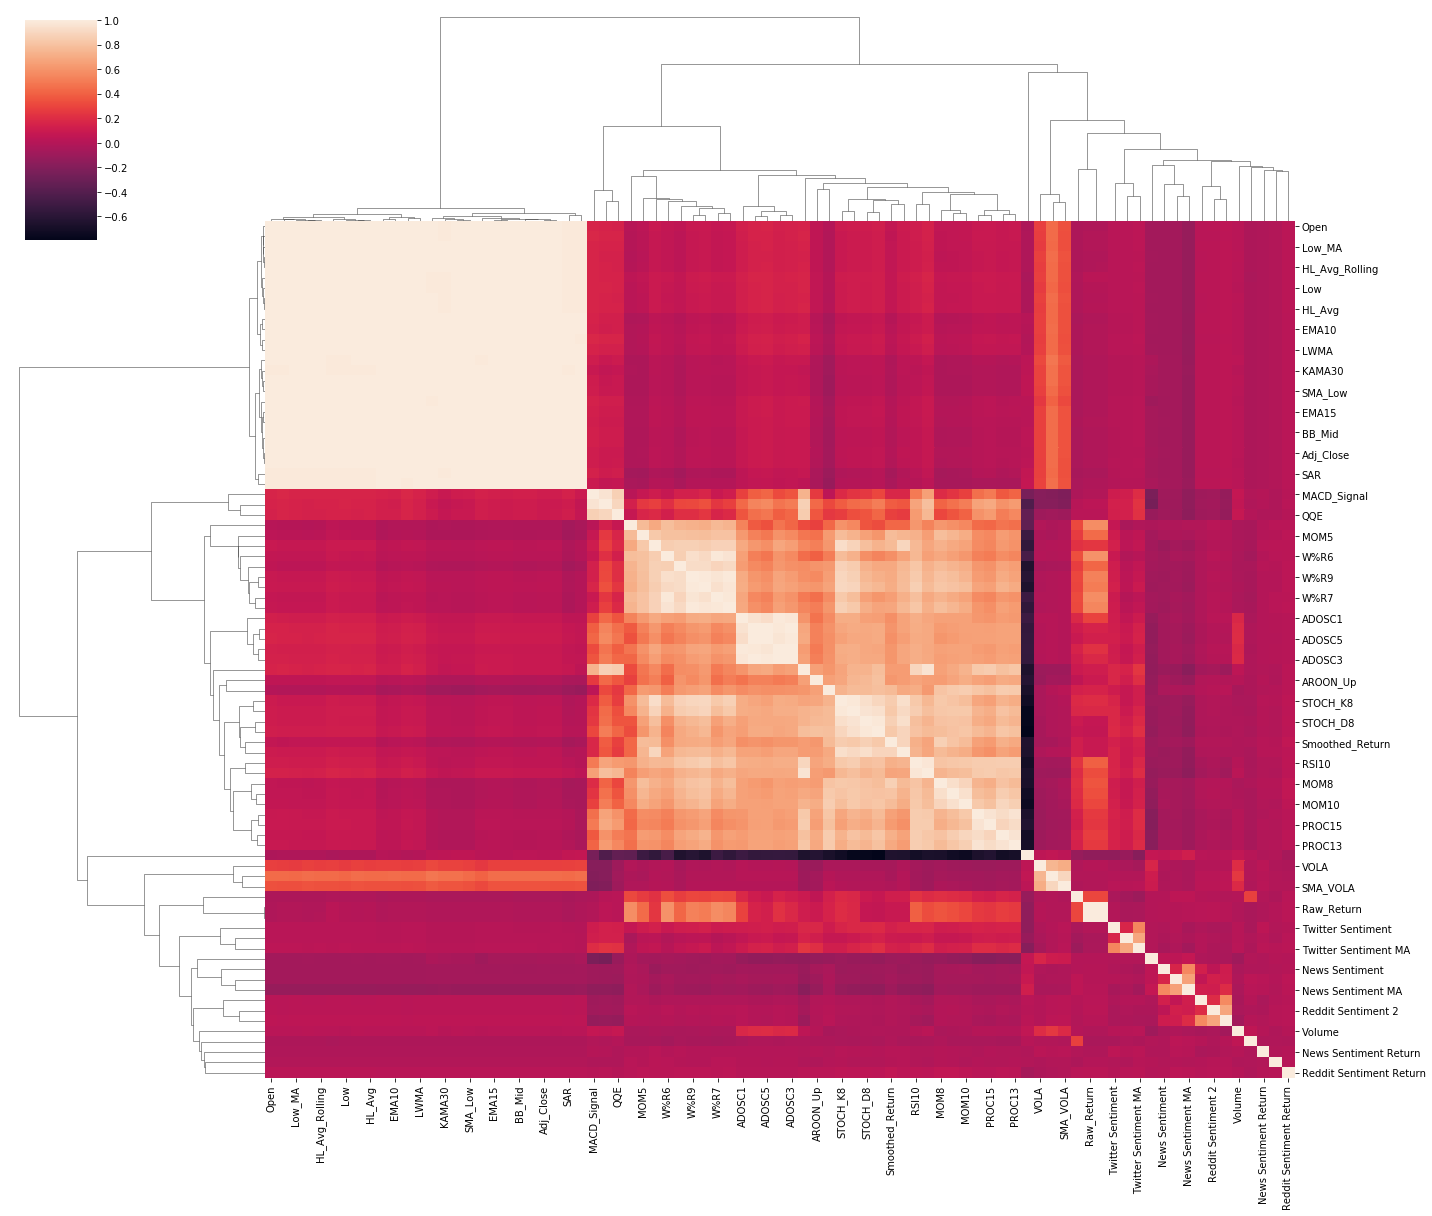

In [32]:
#plot cross correlation of input features
correlation_data = df.corr()

sns.clustermap(correlation_data, figsize=(20,17))

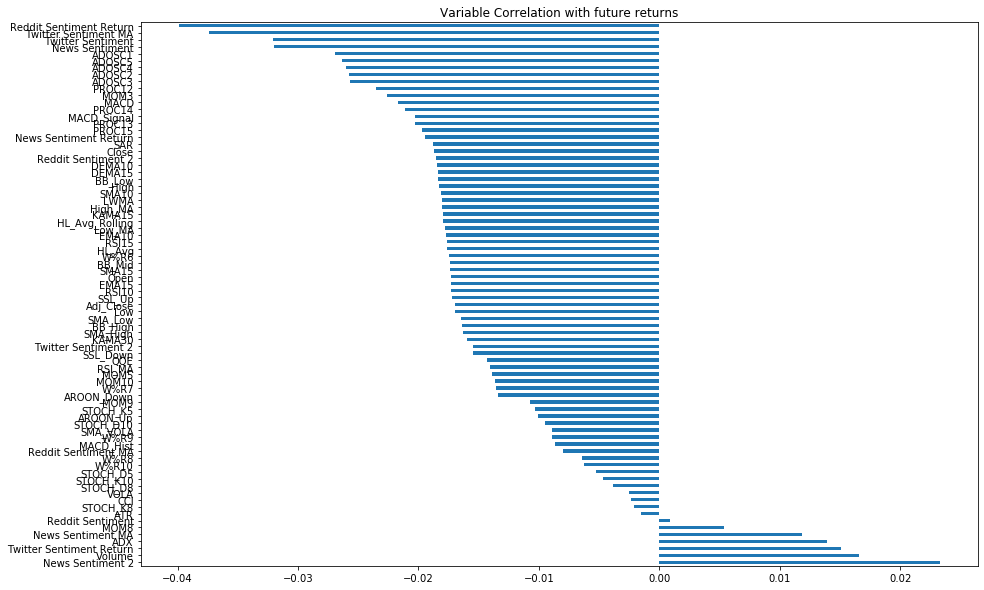

In [33]:
#plot correlation of input features with output variable log returns
corr_sent = df.copy().drop(columns=['Raw_Return','Raw_Labels','Smoothed_Labels','Smoothed_Return','Return']).corrwith(df.Raw_Return.shift(-1))

fig, ax = plt.subplots(figsize=(15,10))

corr_sent.sort_values(ascending=False).plot.barh(title='Variable Correlation with future returns', ax=ax)

It can be observed that the engineered sentiment features correlate the most with next day returns. This motivates the use of Sentiment and Fundamental analysis for feature engineering.

In [79]:
#Manual Correlation Feature Selection Algorithm
def correlation(dataset, threshold):
    col_corr = set() 
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if (corr_matrix.iloc[i, j] >= threshold) and (corr_matrix.columns[j] not in col_corr):
                colname = corr_matrix.columns[i] # getting the name of column
                col_corr.add(colname)
                if colname in dataset.columns:
                    del dataset[colname] # deleting the column from the dataset

    print("Remaining colums:", dataset.columns)
    print("Number of remaining columns:", len(dataset.columns))
    print("Number of removed columns:", len(col_corr))
    return dataset.columns

In [80]:
test_manual = df.copy()
manual_selected = correlation(test_manual, 0.5)

Remaining colums: Index(['Open', 'Volume', 'Raw_Return', 'Smoothed_Return', 'ATR', 'ADX',
       'AROON_Down', 'MACD', 'Reddit Sentiment', 'Twitter Sentiment',
       'News Sentiment', 'Twitter Sentiment 2', 'Reddit Sentiment 2',
       'News Sentiment 2', 'Twitter Sentiment Return',
       'Reddit Sentiment Return', 'News Sentiment Return', 'Raw_Labels',
       'Smoothed_Labels'],
      dtype='object')
Number of remaining columns: 19
Number of removed columns: 64


From the naive analysis it can be further observed how a range of Technical, Sentiment and Fundamental features are retained.

## 8.3 Dimensionality Reduction - PCA

Here, PCA is used as a dimensionality reduction tool to observe how separable the dataset it. It can also be used as a feature selection tool. however, the context of features is lost in this way and so is used more as a visualization technique.

In [50]:
def pca(df, labels):
    
    plt.rcParams["figure.figsize"] = (15,10)
    
    X_copy = df.copy()

    scaler = StandardScaler()

    X_copy_scaled = scaler.fit_transform(X_copy)

    pca = PCA(n_components=3)

    pca.fit(X_copy_scaled)

    X_pca=pd.DataFrame(pca.transform(X_copy_scaled), columns=['PCA%i' % i for i in range(3)])

    print("Old Shape: ", X_copy.shape)

    print("New Shape: ", X_pca.shape)
    
    fig = plt.figure()

    ax = fig.add_subplot(111, projection='3d')

    plot_colours = []

    for i in df[labels].astype(int):

        if i == 1:

            plot_colours.append('blue')

        else:

            plot_colours.append('yellow')

    ax.scatter(X_pca['PCA0'], X_pca['PCA1'], X_pca['PCA2'], c=plot_colours, cmap="Set2_r", s=60)

    # make simple, bare axis lines through space:
    xAxisLine = ((min(X_pca['PCA0']), max(X_pca['PCA0'])), (0, 0), (0,0))
    ax.plot(xAxisLine[0], xAxisLine[1], xAxisLine[2], 'r')
    yAxisLine = ((0, 0), (min(X_pca['PCA1']), max(X_pca['PCA1'])), (0,0))
    ax.plot(yAxisLine[0], yAxisLine[1], yAxisLine[2], 'r')
    zAxisLine = ((0, 0), (0,0), (min(X_pca['PCA2']), max(X_pca['PCA2'])))
    ax.plot(zAxisLine[0], zAxisLine[1], zAxisLine[2], 'r')

    # label the axes
    ax.set_xlabel("PC1")
    ax.set_ylabel("PC2")
    ax.set_zlabel("PC3")
    ax.set_title("Top 3 Principal Components")

    plt.show()

Old Shape:  (2053, 83)
New Shape:  (2053, 3)


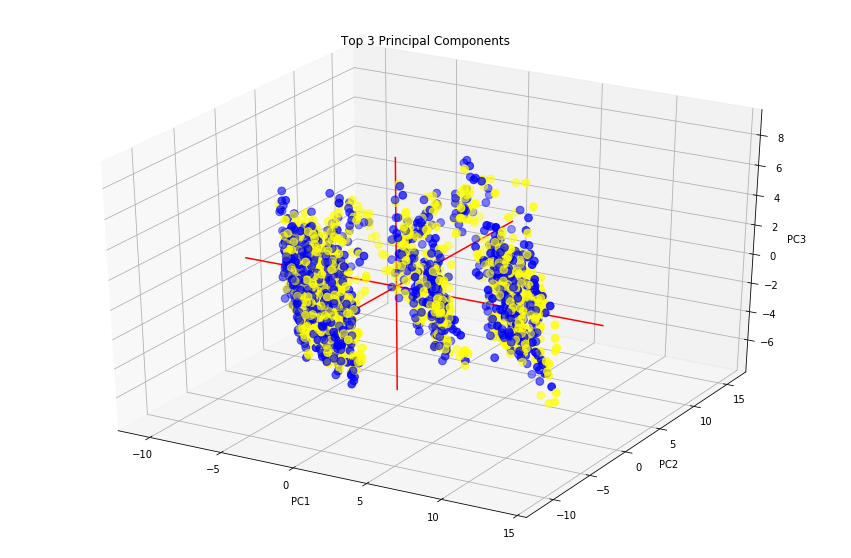

In [51]:
pca(df, 'Raw_Labels')

## 8.4 Machine Learning Feature Selection - RFE-CV

In this section an RFE wrapper approach is used to select optimal features within the masterframe.

In [76]:
#function to make splits for time series
def get_split(df, train_size, label_type):
    
        #Split data for time series
        X = df.copy().drop(columns=['Open','High','Low','Close','Volume','Return','Raw_Return','Smoothed_Return'
                                   , 'Smoothed_Labels', 'Raw_Labels'])

        if label_type == "RAW":
            y = df.Raw_Labels
        else:
            y = df.Smoothed_Labels
            
        split = int(len(X)*train_size)

        X_train = X[:split]
        X_test = X[split+1:]
        
        #Scale data for better logistic regression model optimization
        scaler = StandardScaler()
        
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)

        y_train = y[:split]
        y_test = y[split+1:]
        
        #Return sets
        return X_train, X_test, y_train, y_test

#function for feature selection between range of number of features
def feature_selection(df, num_min, num_max, label_type):

    #Get data split
    X_train, X_test, y_train, y_test = get_split(df, 0.7, label_type)
    
    #Define range of number of features to test for
    feature_n = range(num_min,num_max)

    #Hold tuple of all accuracies, num of features, feature selection models and fitted classifiers
    acc_list = []

    for i in feature_n:

        #output what number of feature is being found
        clear_output(wait=True)
        print(f'Optimizing for {i} features...')

        #classifier to base accuracies from
        model = LogisticRegression(max_iter=1000, n_jobs=-1)
    
        #Define RFE model and fit to data
        rfe = RFE(model, n_features_to_select=i)

        X_train_rfe = rfe.fit_transform(X_train, y_train)

        X_test_rfe = rfe.transform(X_test)

        model.fit(X_train_rfe,y_train)

        pred = model.predict(X_test_rfe)
        
        #get accuracy
        accuracy = model.score(X_test_rfe, y_test)

        #add tuple to list for searching later
        acc_list.append((i,accuracy,rfe,model))

    #sort tuple list to get best performing classifier
    acc_sorted = sorted(acc_list, key=lambda tup: tup[1], reverse=True)
    
    return acc_sorted

def selection_report(df, models, label_type):

    og_columns = df.copy().drop(columns=['Open','High','Low','Close','Volume','Return','Raw_Return','Smoothed_Return'
                                   , 'Smoothed_Labels', 'Raw_Labels']).columns
    
    X_train, X_test, y_train, y_test = get_split(df, 0.7, label_type)
        
    fig, ax = plt.subplots(figsize=(7, 7))

    #get feature selection model
    rfe = models[0][2]

    #transform dataframe to only best feature set
    X_train_rfe = rfe.fit_transform(X_train, y_train)

    X_test_rfe = rfe.transform(X_test) 

    #get best classifier from feature selection method
    clf = models[0][3]

    #predict x_test
    pred = clf.predict(X_test_rfe)
    
    #get f1 score for best model
    f1 = f1_score(y_test, pred, average='weighted')
    
    #get list of feature for best model
    feature_list = pd.Series(models[0][2].support_, index=og_columns)

    best_features = list(feature_list[feature_list==True].index)
    
    #output results
    print("The best number of features is " + str(models[0][0]) + " with an Accuracy of " + str(models[0][1]))

    print("The best model for optimal number of features has f1 score of", f1)
    
    print("The optimum list of features is: ", best_features)
    
    print(classification_report(pred,y_test))
    
    titles_options = [("Confusion matrix, without normalization", None)]

    disp = plot_confusion_matrix(clf, X_test_rfe, y_test,                           
                                 display_labels=[-1,1],
                                 cmap=plt.cm.Blues, ax=ax)

    disp.ax_.set_title("Confusion Matrix")
    
    return best_features

Optimizing for 24 features...
The best number of features is 7 with an Accuracy of 0.5463414634146342
The best model for optimal number of features has f1 score of 0.5449411233571382
The optimum list of features is:  ['W%R7', 'W%R8', 'W%R9', 'SMA_High', 'SSL_Up', 'RSI10', 'KAMA15']
              precision    recall  f1-score   support

          -1       0.61      0.52      0.56       345
           1       0.49      0.58      0.53       270

    accuracy                           0.55       615
   macro avg       0.55      0.55      0.55       615
weighted avg       0.56      0.55      0.55       615



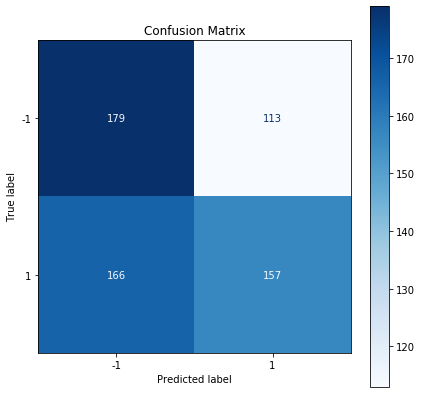

In [77]:
acc_sorted = feature_selection(df,5,25,'RAW')
selected_features = selection_report(df,acc_sorted,'RAW')

In [84]:
selected_features_set = set(selected_features)
manual_selected_set = set(manual_selected.to_list())

diff = manual_selected_set - selected_features_set

selected = selected_features + list(diff)

selected

['W%R7',
 'W%R8',
 'W%R9',
 'SMA_High',
 'SSL_Up',
 'RSI10',
 'KAMA15',
 'Reddit Sentiment',
 'News Sentiment',
 'Open',
 'Volume',
 'Reddit Sentiment Return',
 'Twitter Sentiment 2',
 'ATR',
 'Raw_Labels',
 'Twitter Sentiment Return',
 'News Sentiment 2',
 'AROON_Down',
 'Twitter Sentiment',
 'Smoothed_Return',
 'Reddit Sentiment 2',
 'News Sentiment Return',
 'Smoothed_Labels',
 'Raw_Return',
 'ADX',
 'MACD']

In [85]:
selected_df = df[selected]
selected_df

,W%R7,W%R8,W%R9,SMA_High,SSL_Up,RSI10,KAMA15,Reddit Sentiment,News Sentiment,Open,...,News Sentiment 2,AROON_Down,Twitter Sentiment,Smoothed_Return,Reddit Sentiment 2,News Sentiment Return,Smoothed_Labels,Raw_Return,ADX,MACD
Date,,,,,,,,,,,,,,,,,,,,,
2011-02-19,-8.403361,-8.403361,-8.403361,1.010371,1.010371,59.990992,1.011040,0.6369,0.196048,1.01370,...,0.196048,60.0,0.851900,0.010092,0.6369,2.052308,-1,-0.000601,19.323494,0.004652
2011-02-20,-29.645191,-29.645191,-29.645191,1.011127,1.011127,53.611986,1.011015,0.4990,0.598400,1.01426,...,0.196048,50.0,0.726833,0.011498,0.6369,2.052308,-1,-0.004497,18.157370,0.004652
2011-02-21,-78.898226,-78.898226,-78.898226,1.011687,1.003214,42.083394,1.010499,0.3611,-0.070585,1.00952,...,0.196048,40.0,0.601767,0.008067,0.6369,-1.117956,1,-0.010505,18.236823,0.004652
2011-02-22,-67.987958,-63.258637,-63.258637,1.012035,1.003791,46.167603,1.010283,0.2232,-0.181338,0.99898,...,0.598400,30.0,0.476700,0.002767,0.4990,1.569088,1,0.003348,18.308330,0.004652
2011-02-23,-36.706869,-35.122930,-32.679739,1.011910,1.003982,53.319115,1.010269,0.0853,-0.276003,1.00234,...,-0.070585,20.0,0.238350,-0.002995,0.3611,0.522034,1,0.006513,16.529712,0.004652
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-24,-94.069767,-94.879518,-95.258020,0.724185,0.718353,27.836514,0.712327,0.0000,-0.466744,0.70572,...,-0.409500,80.0,-0.700300,-0.017333,-0.4215,1.292208,-1,-0.002609,33.874403,-0.003458
2018-12-25,-78.313953,-78.313953,-81.275100,0.722904,0.717411,34.420872,0.711604,-0.6249,-0.729867,0.70428,...,-0.203622,70.0,-0.696495,-0.016345,-0.2960,0.563739,-1,0.003841,35.885157,-0.003706
2018-12-26,-90.261153,-90.412426,-90.412426,0.721572,0.716019,30.526674,0.710517,0.0000,-0.697500,0.70693,...,-0.466744,100.0,-0.692691,-0.013739,0.0000,-0.044346,-1,-0.004835,38.039262,-0.004086


Old Shape:  (2053, 26)
New Shape:  (2053, 3)


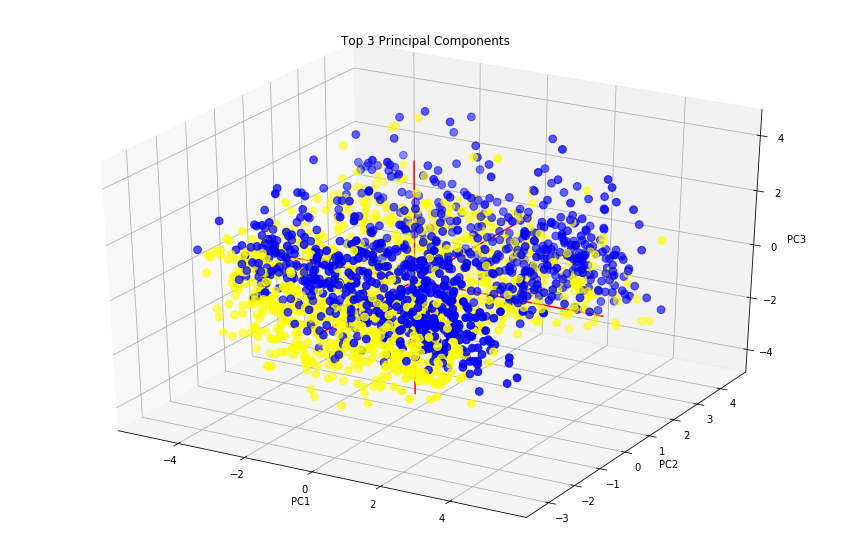

In [88]:
pca(selected_df, 'Smoothed_Labels')

In [86]:
#Saved to csv for use within machine learning models
selected_df.to_csv("./Data/Masterframe_Selected.csv")